In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

from astropy.table import Table
from astropy import units as u
import astropy.constants
from astropy.io import ascii,fits

from scipy.optimize import curve_fit
from astropy import  convolution


DEIMOS_DATA = '/Users/tac1998/thesis/'
#DEIMOS_REDUX = '/Users/mgeha/Projects/DEIMOS/'
#_SPEED_OF_LIGHT =astropy.constants.c.to_value('km/s') 

In [2]:
# Read in sky line wavelengths
skylinefile = DEIMOS_DATA + '/skylines_air.data'
sky_lines = pd.read_csv(skylinefile, sep='\s+')

In [3]:
wavel = sky_lines['Wave']

In [4]:
path_1 = DEIMOS_DATA + '/dra1_exp2/*.dat'
files_1 = glob.glob(path_1)

folder_1 = []

for name in files_1:
    df = pd.read_csv(name, sep='\s+')
    df['S/N'] = df['FLUX'] * np.sqrt(df['IVAR'])
    ivar = df['IVAR']
    df['VAR'] = np.sqrt(1/(ivar))
    folder_1.append(df)

for file in folder_1:
    med = file['SKY'].median()
    std = file['SKY'].std()
    file.plot(x='WAVE', y='SKY', title=name, ylim=[med - 10*std, med + 10*std])
    for w in wavel:
        plt.axvline(x=w, color='red')

# Try out fitting gaussian to one line in a slit

In [5]:
from scipy.optimize import curve_fit

def gaussian(x,*p) :
    # A gaussian peak with:
    #   Constant Background          : p[0]
    #   Peak height above background : p[1]
    #   Central value                : p[2]
    #   Standard deviation           : p[3]
    return p[0]+p[1]*np.exp(-1.*(x-p[2])**2/(2.*p[3]**2))

def gauss_guess(x,y):
    norm = np.median(np.percentile(y,50))
    ind = sky.index(max(sky))
    w = x[ind]
    N_guess = np.max(y) - np.min(y)
    sig_guess = 0.5
    p0 = [norm,N_guess,w,sig_guess]

    return p0

In [7]:
# testing out indivudual files for same skyline
file_name = DEIMOS_DATA + '/dra1_exp2/dra1_exp2_129.dat'

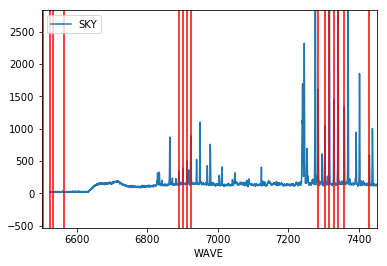

In [8]:
one_df = pd.read_csv(file_name, sep='\s+')
ivar = one_df['IVAR']
one_df['VAR'] = np.sqrt(1/(ivar))
med = one_df['SKY'].median()
std = one_df['SKY'].std()

one_df.plot(x='WAVE', y='SKY', xlim=[6500,7450], ylim=[med - (std),med + (std*4)])
for w in wavel:
    plt.axvline(x=w, color='red')

/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


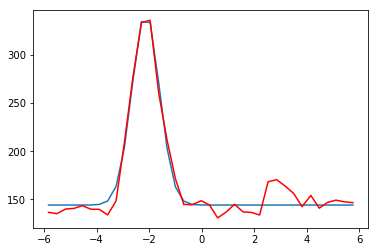

In [9]:
sline = 6891.1999999999998
#sline = 6564.85
plus = sline + 6
minus = sline - 6

msk_10A = one_df['WAVE'].between(minus, plus, inclusive=True)
gauss_range = one_df[msk_10A]
gauss_range['WAVE'] -= sline

waves = list(gauss_range['WAVE'])
sky = list(gauss_range['SKY'])
var = list(gauss_range['VAR'])

guesses = gauss_guess(waves, sky)

popt, pcov = curve_fit(gaussian, waves, sky, guesses, sigma=var)

plt.plot(waves, gaussian(waves, *popt))

plt.plot(waves, sky, color='red')

# Now loop through all slits in folder

/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


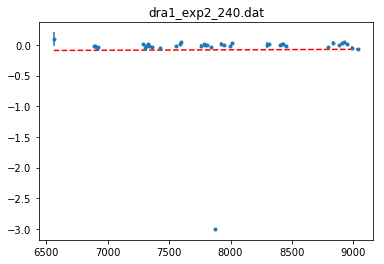

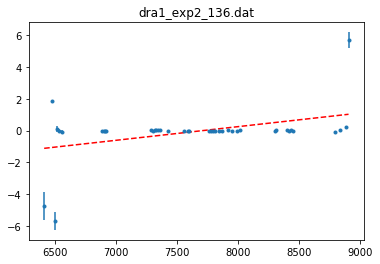

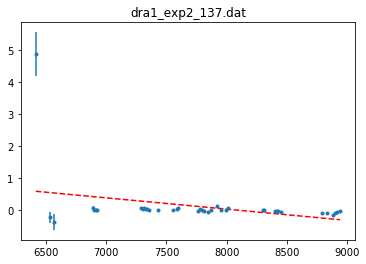

/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt


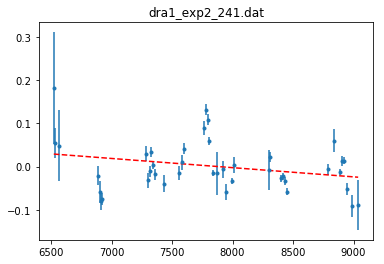

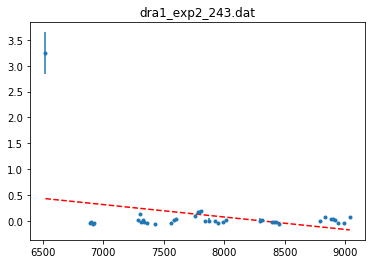

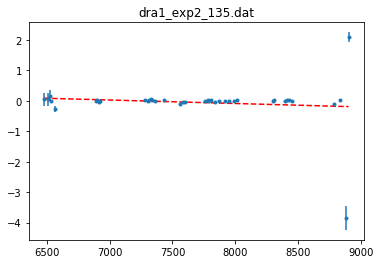

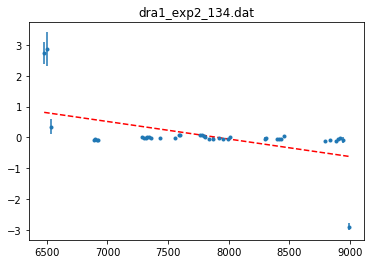

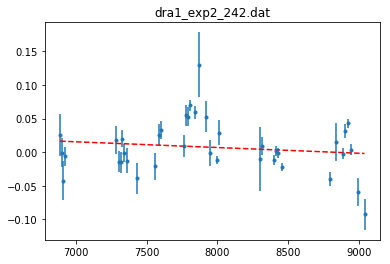

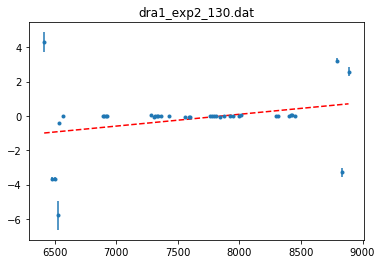

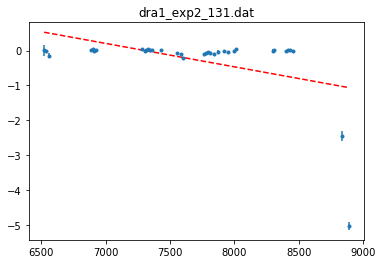

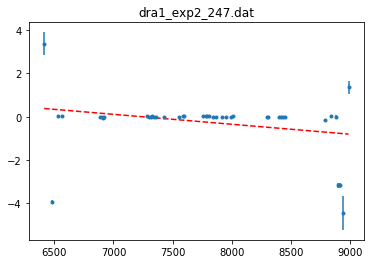

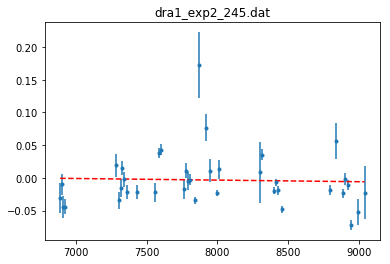

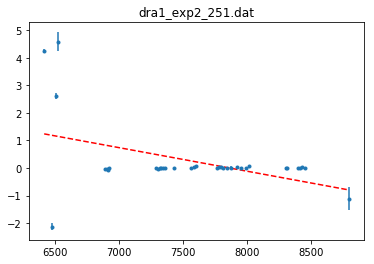

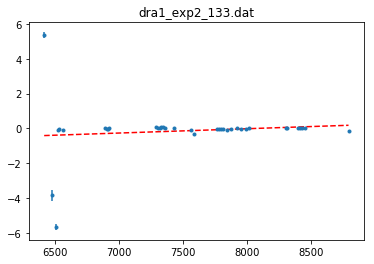

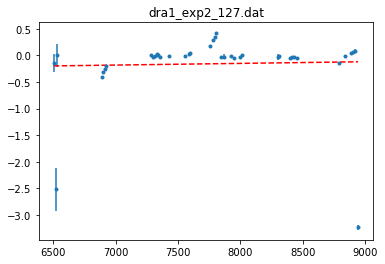

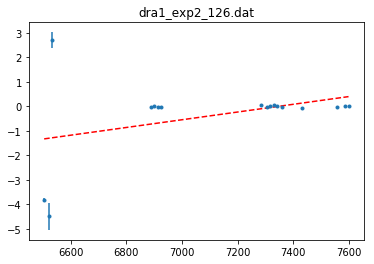

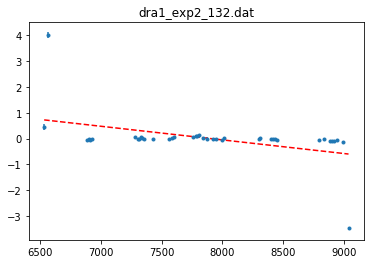

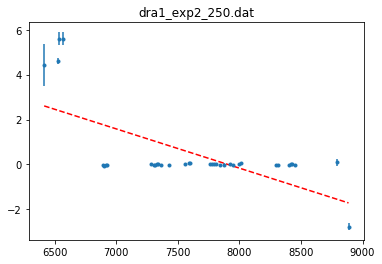

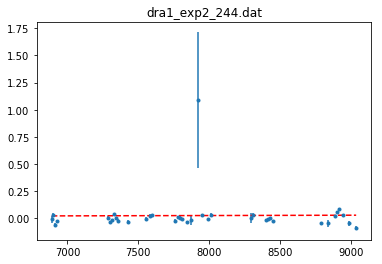

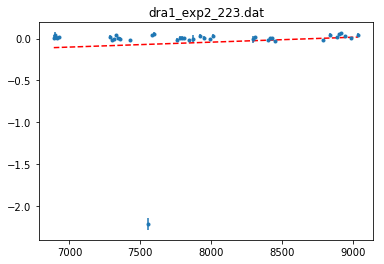

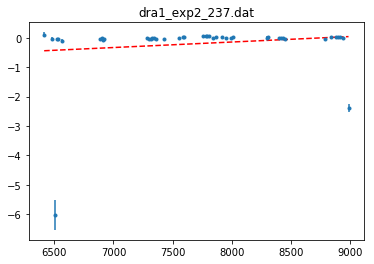

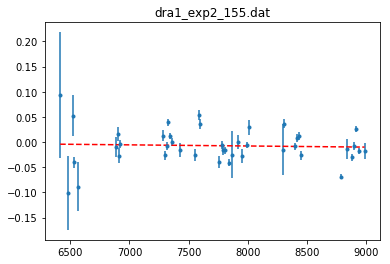

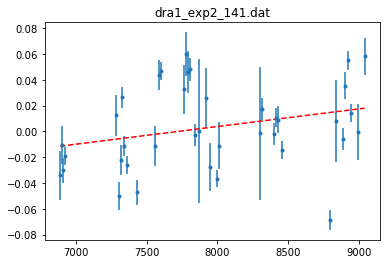

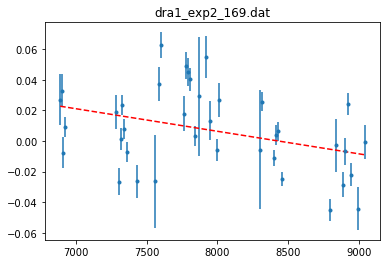

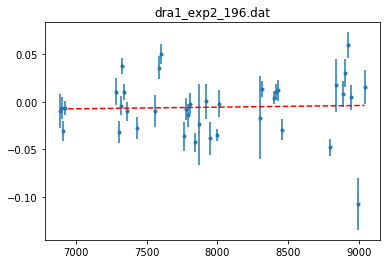

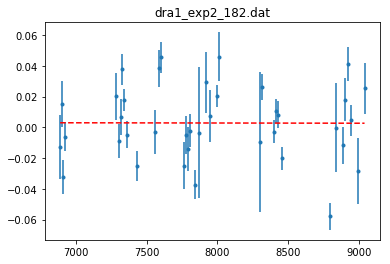

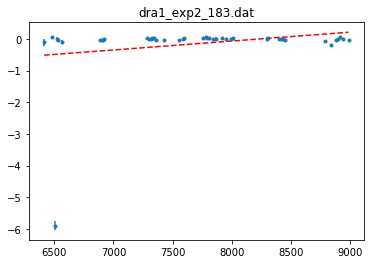

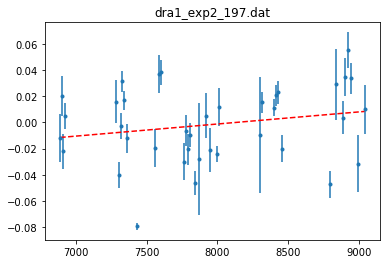

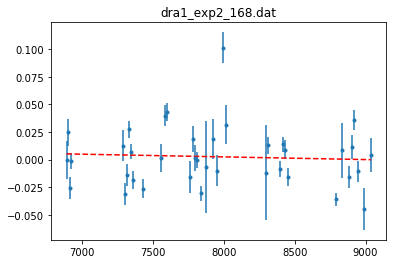

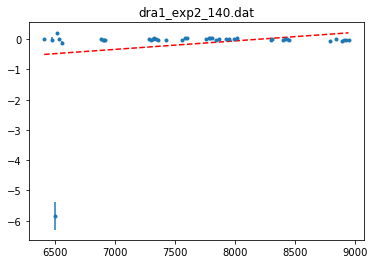

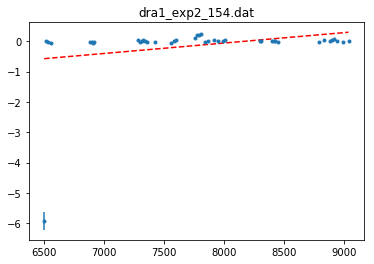

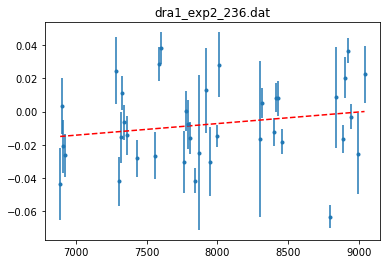

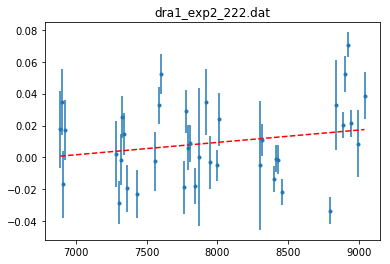

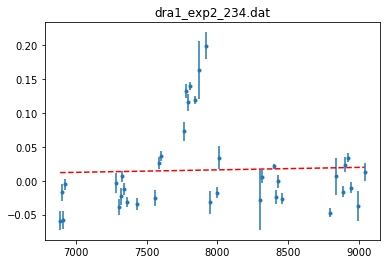

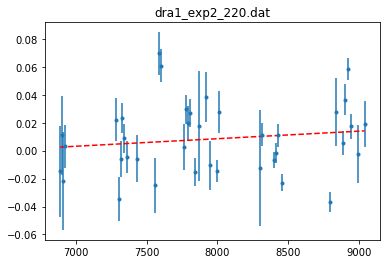

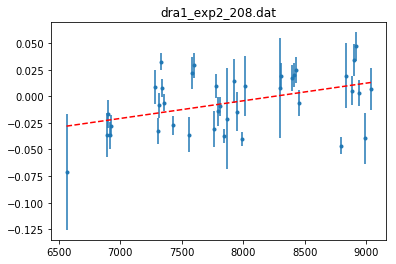

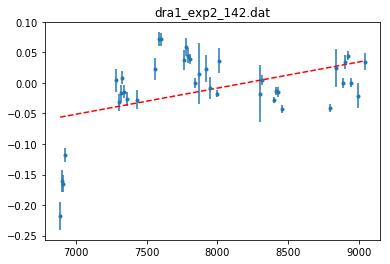

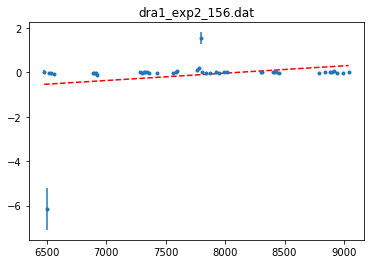

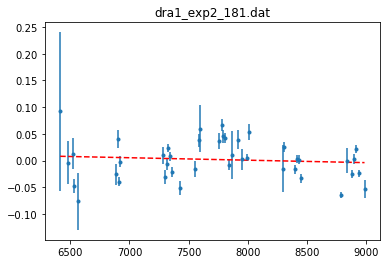

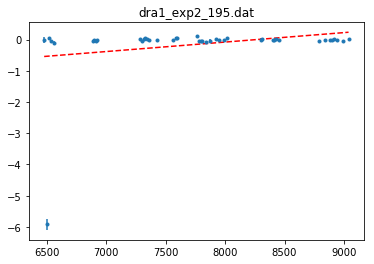

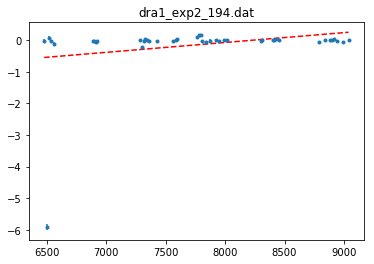

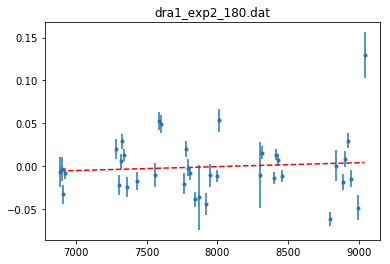

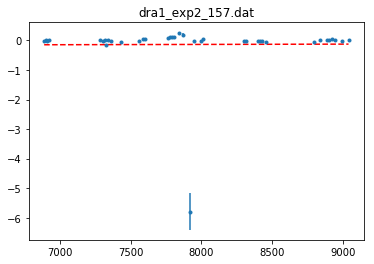

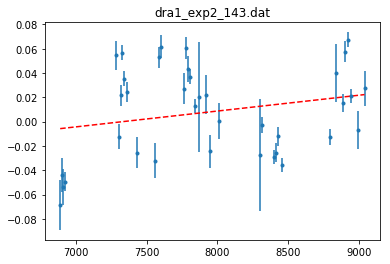

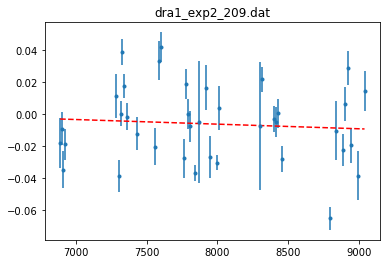

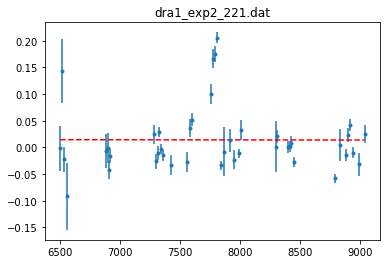

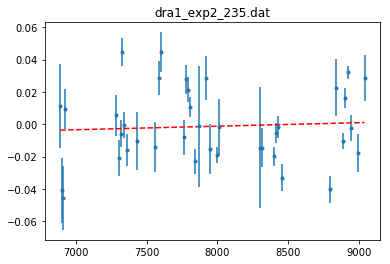

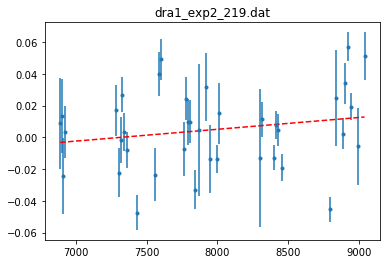

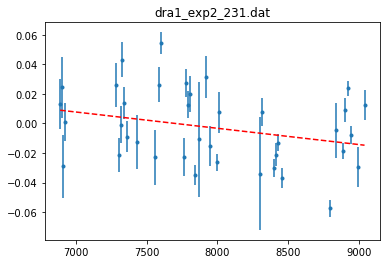

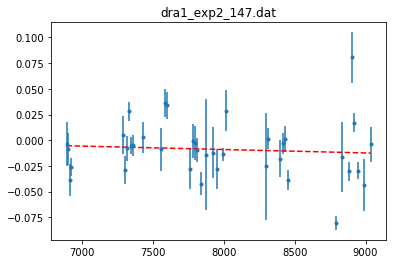

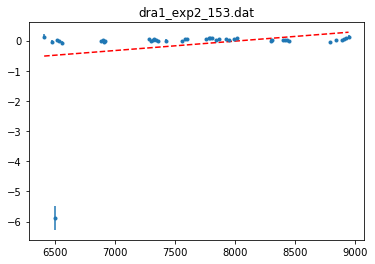

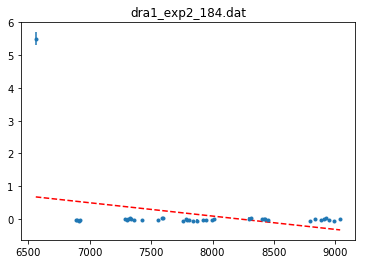

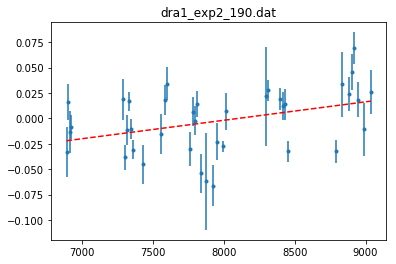

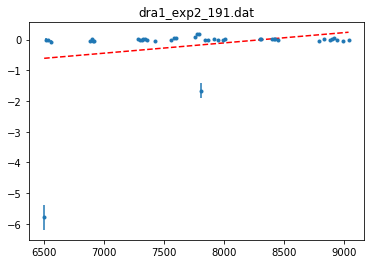

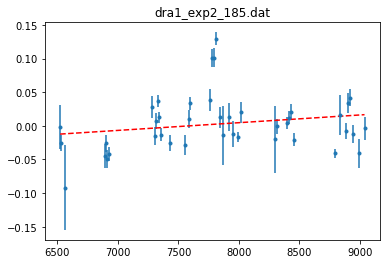

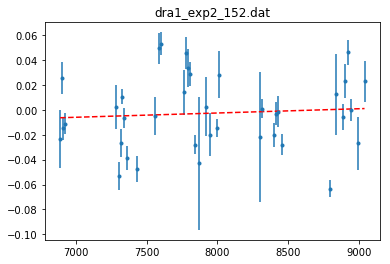

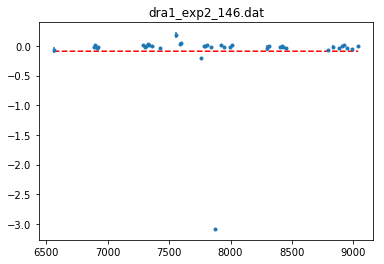

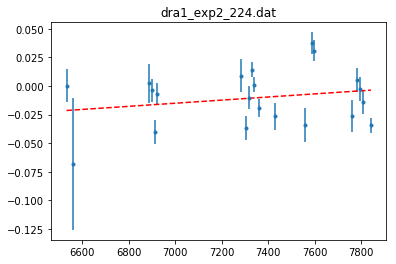

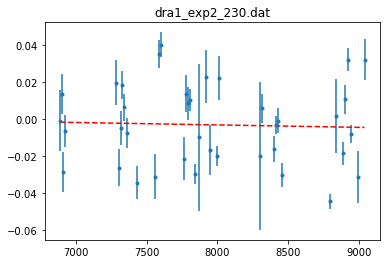

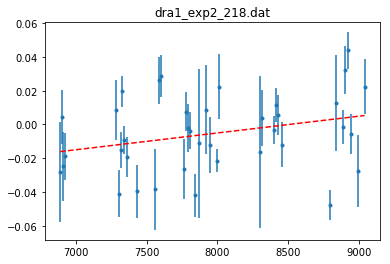

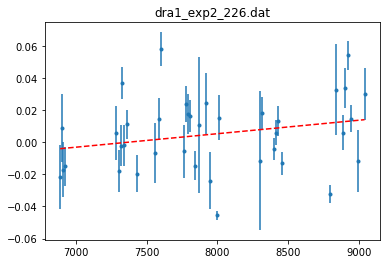

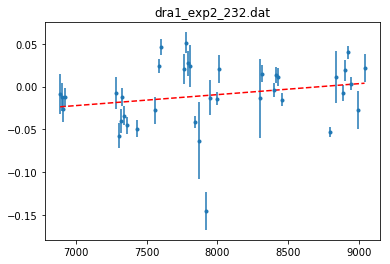

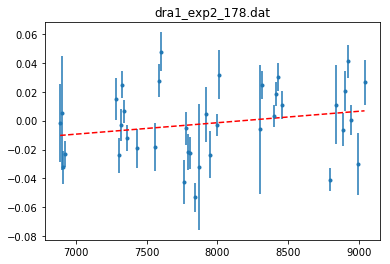

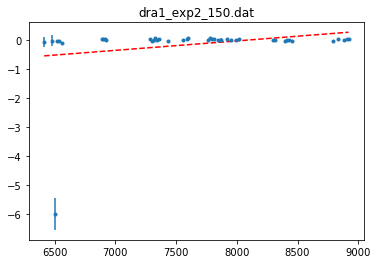

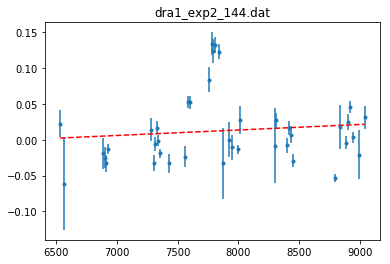

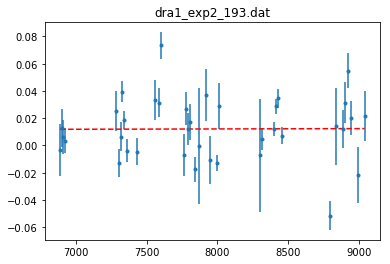

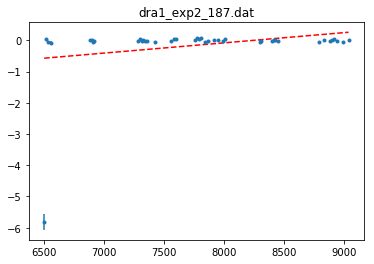

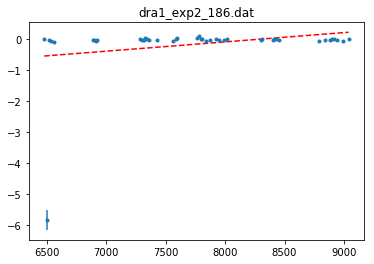

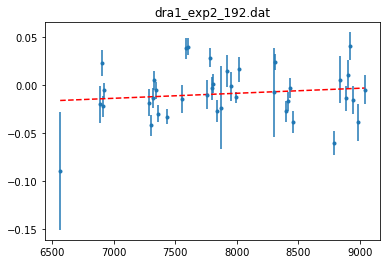

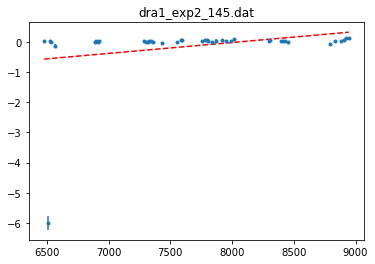

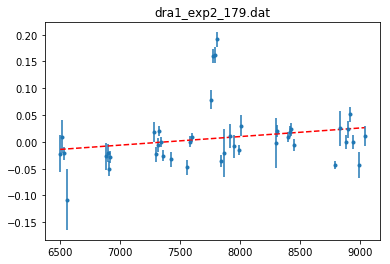

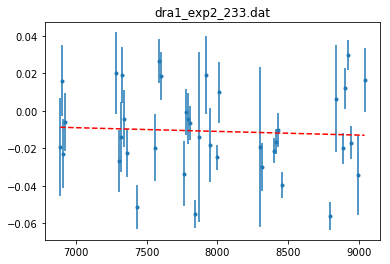

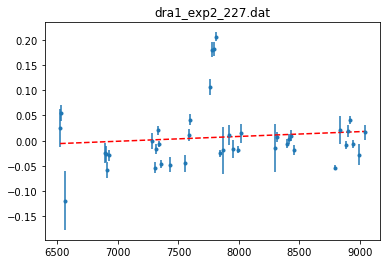

/Users/tac1998/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


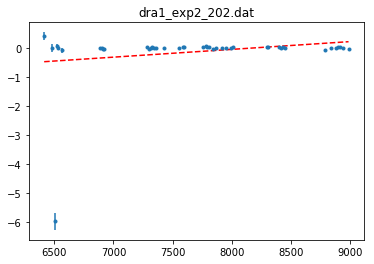

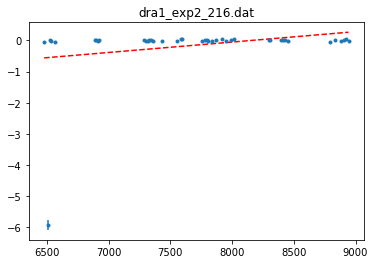

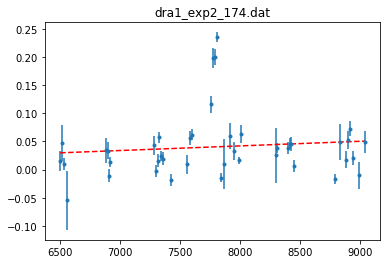

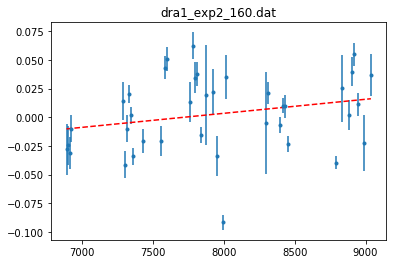

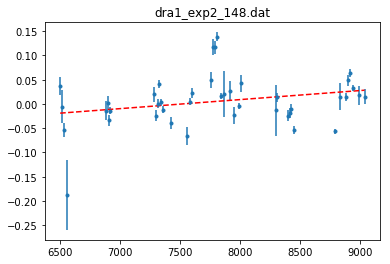

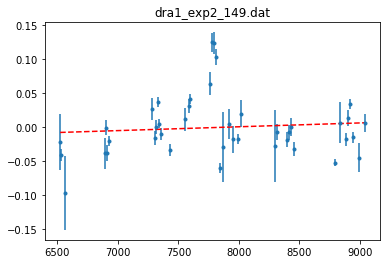

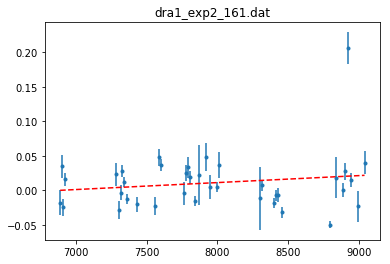

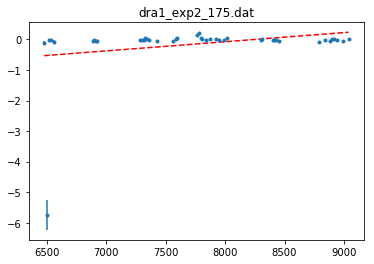

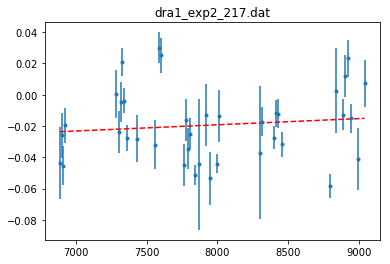

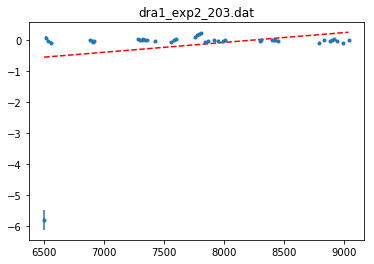

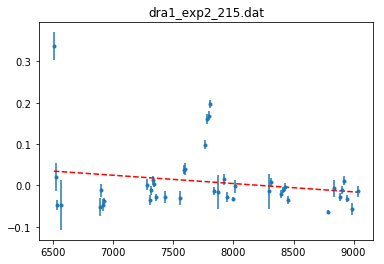

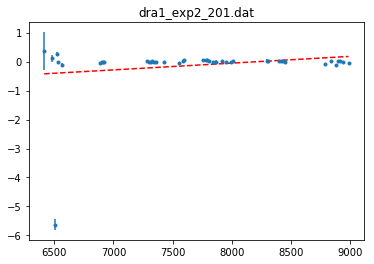

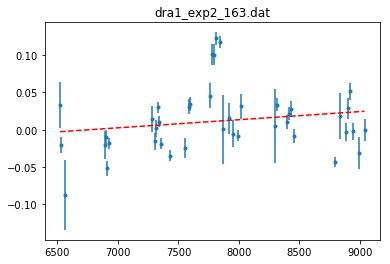

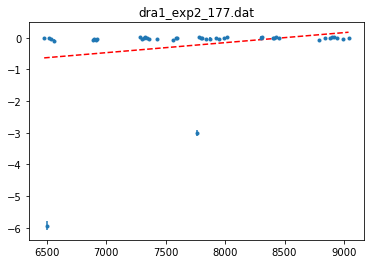

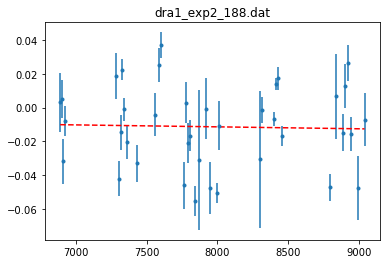

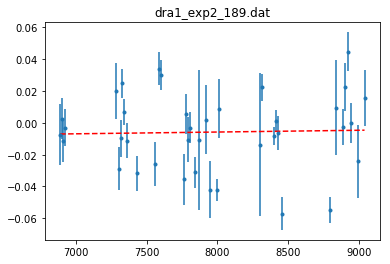

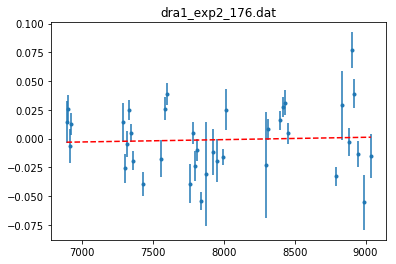

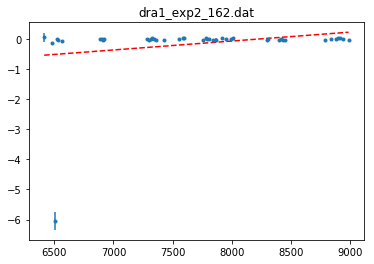

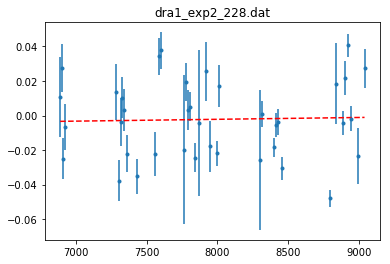

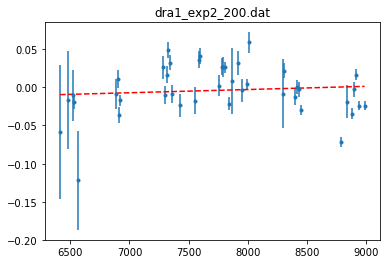

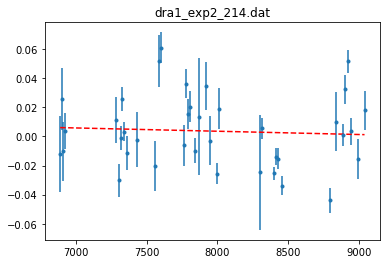

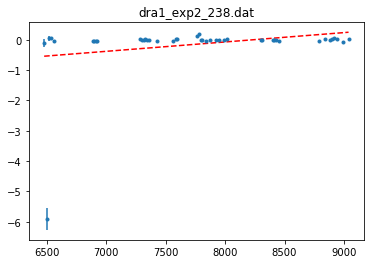

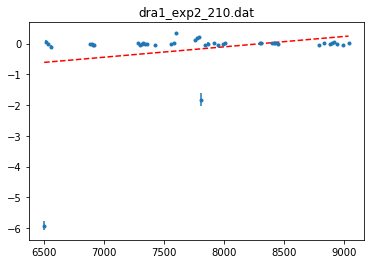

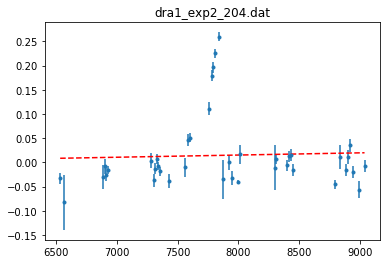

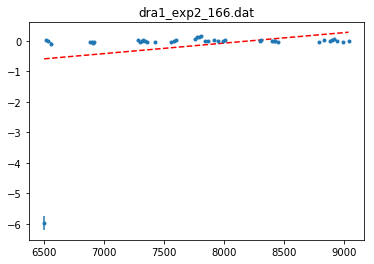

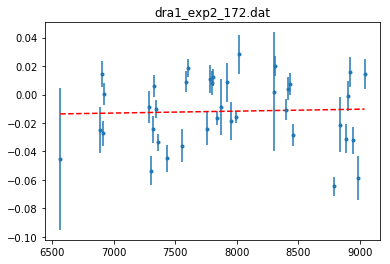

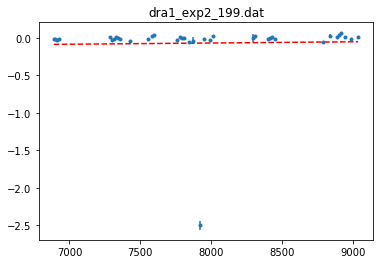

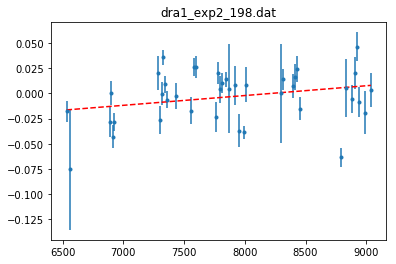

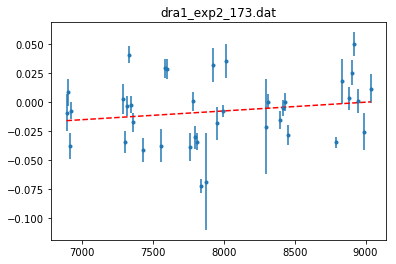

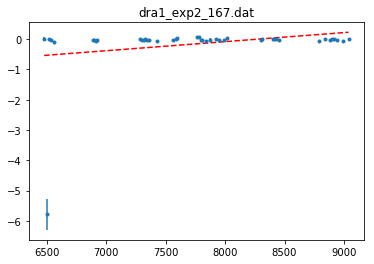

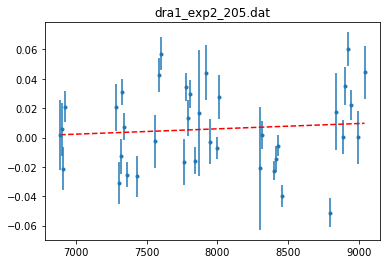

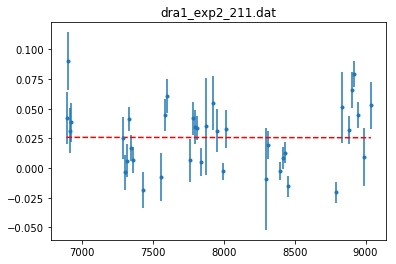

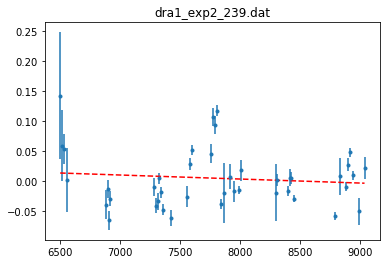

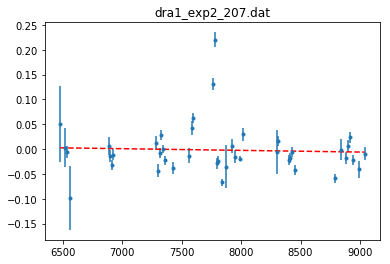

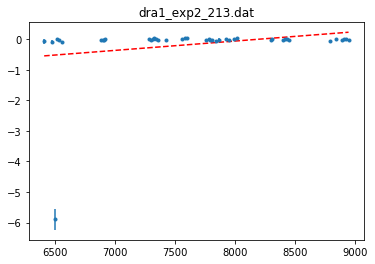

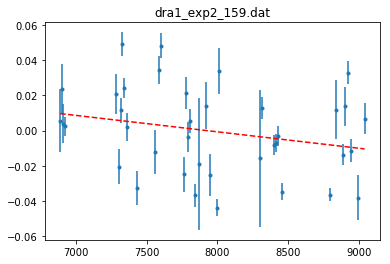

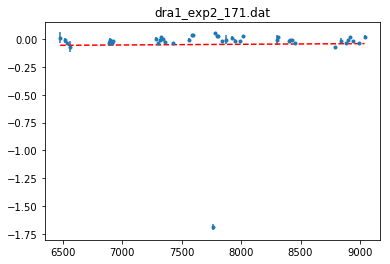

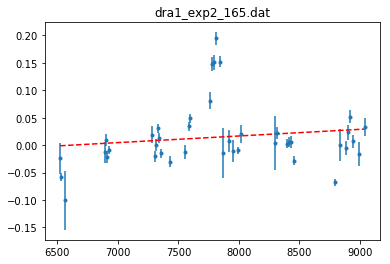

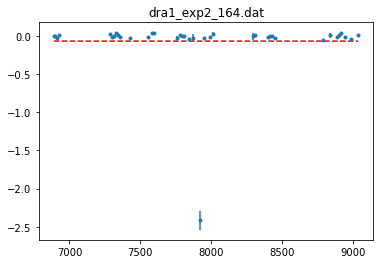

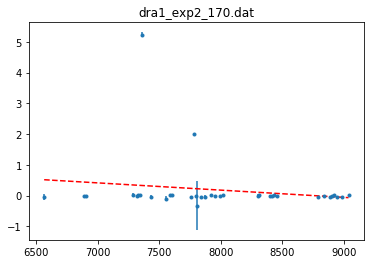

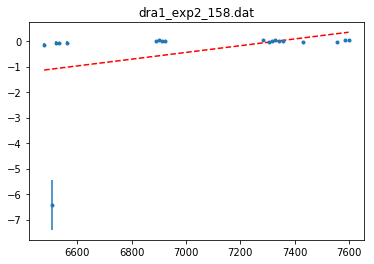

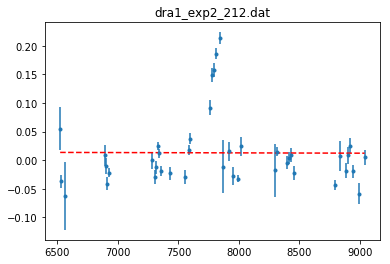

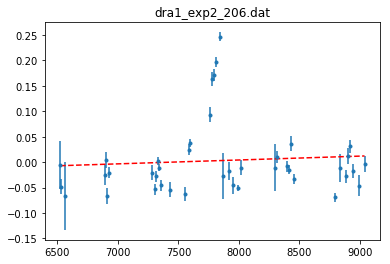

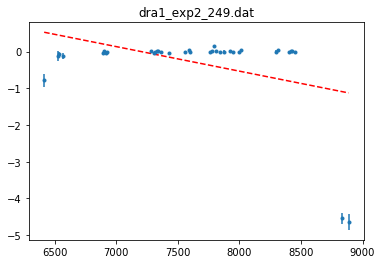

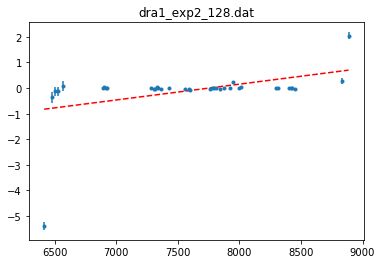

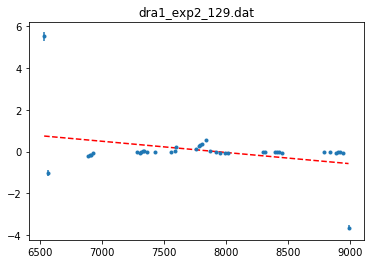

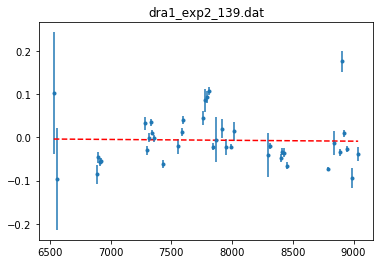

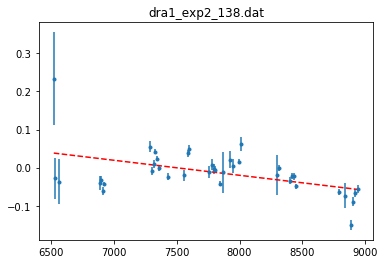

In [28]:
for f in files_1:
    
    line_centers = []
    line_center_err = []
    kernel = []
    kernel_err = []
    bad_slits = []

    cent_use_waves = []
    kern_use_waves = []

    for w in wavel:

        one_file = pd.read_csv(f, sep='\s+')
        
        fname = str(f)
        slit_name = fname[-17:]
        
        ivar = one_file['IVAR']
        one_file['VAR'] = np.sqrt(1/(ivar))

        sline = w
        plus = sline + 6
        minus = sline - 6

        msk_10A = one_file['WAVE'].between(minus, plus, inclusive=True)
        gauss_range = one_file[msk_10A]
        gauss_range['WAVE'] -= sline

        if gauss_range.empty:
            pass

        else:
            try:
                waves = list(gauss_range['WAVE'])
                sky = list(gauss_range['SKY'])
                var = list(gauss_range['VAR'])

                std = gauss_range['SKY'].std()
                mean = gauss_range['SKY'].mean()
                mx = np.max(sky)

                guesses = gauss_guess(waves, sky)

                popt, pcov = curve_fit(gaussian, waves, sky, guesses, sigma=var)
                
            except (RuntimeError, TypeError):
                bad_slits.append(slit_name)
                    
            param_err = np.sqrt(np.diag(pcov))

            center = popt[2]
            center_err = param_err[2]

            width = popt[3]
            width_err = param_err[3]
            
            if center_err < 1:
                line_centers.append(center)
                line_center_err.append(center_err)
                cent_use_waves.append(w)
            
            if width_err < 1:
                kernel.append(width)
                kernel_err.append(width_err)
                kern_use_waves.append(w)
            
        
        #plt.plot(waves, gaussian(waves, *popt))
        #plt.plot(waves, sky, color='red')
        #plt.title(w)
        #plt.show()
        
    std = np.std(line_center_err)
    mean_centers = np.mean(line_centers)

    plt.errorbar(cent_use_waves,line_centers, yerr=line_center_err, fmt='.')
    
    fit = np.polyfit(cent_use_waves,line_centers,1)
    fit_fn = np.poly1d(fit) 
    plt.plot(cent_use_waves, fit_fn(cent_use_waves), '--r')
    
    plt.title(slit_name)
    plt.show()

/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


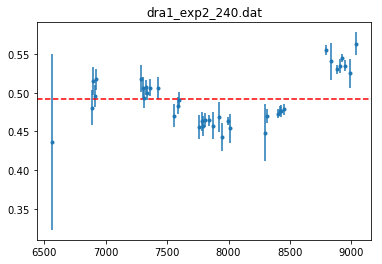

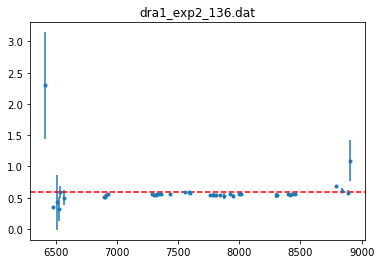

In [29]:
bad_slits_width = []

for f in files_1:
    
    kernel = []
    kernel_err = []

    kern_use_waves = []

    for w in wavel:

        one_file = pd.read_csv(f, sep='\s+')
        
        fname = str(f)
        slit_name = fname[-17:]
        
        ivar = one_file['IVAR']
        one_file['VAR'] = np.sqrt(1/(ivar))

        sline = w
        plus = sline + 6
        minus = sline - 6

        msk_10A = one_file['WAVE'].between(minus, plus, inclusive=True)
        gauss_range = one_file[msk_10A]
        gauss_range['WAVE'] -= sline

        if gauss_range.empty:
            pass

        else:
            try:
                waves = list(gauss_range['WAVE'])
                sky = list(gauss_range['SKY'])
                var = list(gauss_range['VAR'])

                std = gauss_range['SKY'].std()
                mean = gauss_range['SKY'].mean()
                mx = np.max(sky)

                guesses = gauss_guess(waves, sky)

                popt, pcov = curve_fit(gaussian, waves, sky, guesses, sigma=var)
                
            except (RuntimeError, TypeError):
                bad_slits_width.append(slit_name)
                    
            param_err = np.sqrt(np.diag(pcov))
            
            width = popt[3]
            width_err = param_err[3]
            
            if width_err < 1:
                kernel.append(width)
                kernel_err.append(width_err)
                kern_use_waves.append(w)

        
    plt.errorbar(kern_use_waves,kernel, yerr=kernel_err, fmt='.')
    plt.axhline(np.mean(kernel), ls='--', c='red')
    
    plt.title(slit_name)
    plt.show()

<Container object of 3 artists>

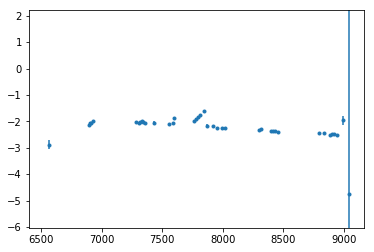

In [76]:
std = np.std(line_center_err)
mean_centers = np.mean(line_centers)

plt.ylim(-std+ mean_centers, std+mean_centers)
plt.errorbar(use_waves,line_centers, yerr=line_center_err, fmt='.')

In [ ]:
    
    gauss_range['WAVE'] -= sline

    waves = list(gauss_range['WAVE'])
    sky = list(gauss_range['SKY'])
    var = list(gauss_range['VAR'])

    guesses = gauss_guess(waves, sky)

    popt, pcov = curve_fit(gaussian, waves, sky, guesses, sigma=var)

    plt.plot(waves, gaussian(waves, *popt))
    plt.plot(waves, sky, color='red')
    plt.title(w)

In [165]:
ivar = gauss_range['IVAR']
gauss_range['VAR'] = np.sqrt(1/(ivar))

/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [142]:
gauss_range['WAVE'].mean()

-0.00509121683440161

In [141]:
def gauss_guess(x,y):
    norm = np.median(np.percentile(y,50))
    w=np.mean(x)
    N_guess   = np.max(y) - np.min(y)
    sig_guess = 0.5
    p0 = [norm,N_guess,w,sig_guess]

    return p0

In [34]:
gauss_range

,WAVE,FLUX,IVAR,SKY
1090,-9.703572,767.481935,0.000934,187.072110
1091,-9.368740,850.549990,0.000897,153.781239
1092,-9.048029,770.883956,0.000931,158.575226
1093,-8.726460,854.563517,0.000917,137.408692
1094,-8.402556,767.101060,0.000948,141.367303
1095,-8.087372,765.505887,0.000996,147.536833
1096,-7.757666,728.871898,0.001029,145.972310
1097,-7.442497,715.113718,0.001017,137.909005
1098,-7.114707,710.859752,0.001039,126.560516
1099,-6.800252,736.856898,0.001041,134.687202


# Fitting a gaussian - for our one slit (IN PROGRESS)

In [148]:
guess = []
sigma = 0.5
for i in range(len(obs_wavelengths)):
    one_guess = obs_wavelengths[i], obs_intensities[i], sigma
    guess.append(one_guess)

In [150]:
popt, pcov = curve_fit(func, obs_wavelengths, obs_intensities, p0=guess)
fit = func(obs_wavelengths, *popt)

TypeError: Improper input: N=132 must not exceed M=44

# Get wavelength v. residual plots for both masks

In [57]:
slit_dfs = []

for file in folder_1:
    
    # Create a DataFrame with the observed wavelengths in one column and the difference between that wavelength and
    # each skyline wavelengths in the following columns
    
    difference = pd.DataFrame(file['WAVE'])
    for w in wavel:
        difference[w] = file['WAVE'].sub(w, axis=0)

    # Make the DataFrame into the absolute values of the differences. Then extract the indices of the minimum
    #differences and put into a list

    abs_difference = difference.abs()

    min_indices = []
    for w in wavel:
        index = abs_difference[w].idxmin() 
        min_indices.append(index)

    # Iterate through all indicies and get the observed wavelength of the minimum differences

    obs_wavelengths = []
    obs_intensities = []
    for m in min_indices:
        obs = file.iloc[m][0]
        intensity = file.iloc[m][3]
        obs_wavelengths.append(obs)
        obs_intensities.append(intensity)
    
    # Join the observed wavelengths onto the original sky lines Data Frame and re-calculate the residuals

    temp_skylines = pd.DataFrame(sky_lines['Wave'])
    temp_skylines['Obs'] = obs_wavelengths
    temp_skylines['Residual'] = temp_skylines['Wave'].sub(temp_skylines['Obs'], axis=0)
    temp_skylines = temp_skylines.loc[abs(temp_skylines['Residual']) < 1]
    
    slit_dfs.append(temp_skylines)

In [58]:
# merge all dataframes together
from functools import reduce

slits_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Wave'],
                                            how='left'), slit_dfs)

In [50]:
cols = [c for c in slits_merged.columns if c[:3] == 'Res']
residuals_merged = slits_merged[cols]

In [51]:
median_difference = residuals_merged.median(axis=1)

In [52]:
sky_lines['Folder_1_Residuals'] = median_difference

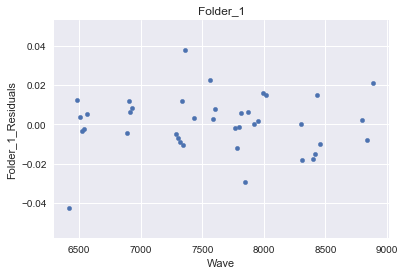

In [74]:
sky_lines.plot.scatter(x='Wave', y='Folder_1_Residuals', title='Folder_1')

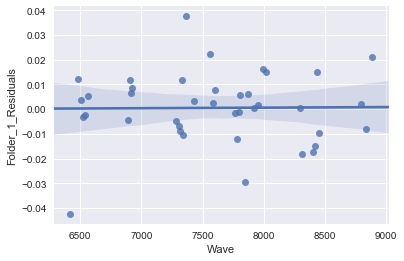

In [76]:
sns.regplot(x=sky_lines['Wave'], y=sky_lines['Folder_1_Residuals'], data=sky_lines);

In [59]:
path_2 = DEIMOS_DATA + '/uss-1/*.dat'
files_2 = glob.glob(path_2)

folder_2 = []

for name in files_2:
    df = pd.read_csv(name, sep='\s+')
    df['S/N'] = df['FLUX'] * np.sqrt(df['IVAR'])
    folder_2.append(df)

In [60]:
slit_dfs2 = []

for file in folder_2:
    
    # Create a DataFrame with the observed wavelengths in one column and the difference between that wavelength and
    # each skyline wavelengths in the following columns
    
    difference = pd.DataFrame(file['WAVE'])
    for w in wavel:
        difference[w] = file['WAVE'].sub(w, axis=0)

    # Make the DataFrame into the absolute values of the differences. Then extract the indices of the minimum
    #differences and put into a list

    abs_difference = difference.abs()

    min_indices = []
    for w in wavel:
        index = abs_difference[w].idxmin() 
        min_indices.append(index)

    # Iterate through all indicies and get the observed wavelength of the minimum differences

    obs_wavelengths = []
    obs_intensities = []
    for m in min_indices:
        obs = file.iloc[m][0]
        intensity = file.iloc[m][3]
        obs_wavelengths.append(obs)
        obs_intensities.append(intensity)
    
    # Join the observed wavelengths onto the original sky lines Data Frame and re-calculate the residuals

    temp_skylines = pd.DataFrame(sky_lines['Wave'])
    temp_skylines['Obs'] = obs_wavelengths
    temp_skylines['Residual'] = temp_skylines['Wave'].sub(temp_skylines['Obs'], axis=0)
    temp_skylines = temp_skylines.loc[abs(temp_skylines['Residual']) < 1]
    
    slit_dfs2.append(temp_skylines)

In [67]:
# merge all dataframes together
from functools import reduce

slits_merged2 = reduce(lambda  left,right: pd.merge(left,right,on=['Wave'],
                                            how='left'), slit_dfs2)

In [68]:
cols2 = [c for c in slits_merged2.columns if c[:3] == 'Res']
residuals_merged2 = slits_merged2[cols2]

In [69]:
median_difference2 = residuals_merged2.median(axis=1)

In [70]:
sky_lines['Folder_2_Residuals'] = median_difference2

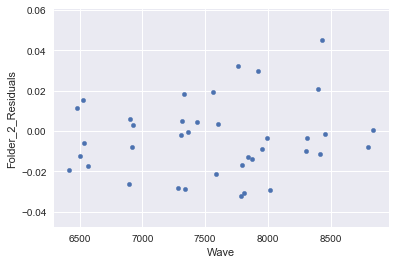

In [71]:
sky_lines.plot.scatter(x='Wave', y='Folder_2_Residuals')

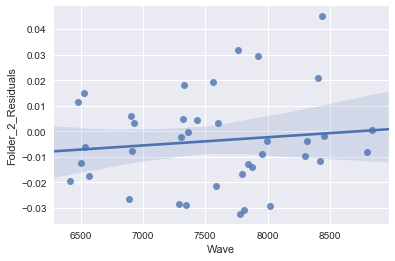

In [72]:
sns.regplot(x=sky_lines['Wave'], y=sky_lines['Folder_2_Residuals'], data=sky_lines);